In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from os import path

## Wykresy i podsumowania wyników metryk
W tym notebooku nie korzystamy z naszego pakietu, służy tylko do analizy danych o metrykach i stworzeniu wykresów do pracy/prezentacji/plakatu.

In [3]:
metrics_dir = path.join('..', '..', 'input', 'sesame_metrics')

## Metrics for input (`Captum`) explanations

In [4]:
df = pd.DataFrame()
for i in range(16):
    df = pd.concat([df,pd.read_csv(path.join(metrics_dir, 'input_explanations_{i}.csv'.format(i=i)), index_col=0)], axis=0)
    
df = df.groupby(by=df.index).mean()

In [5]:
df

,DIR0.0,CIR Same0.0,CIR Max0.0,Average Recall0.0,Average Precision0.0,F1_score0.0,IOU0.0,DIR0.1,CIR Same0.1,CIR Max0.1,...,Average Precision0.8,F1_score0.8,IOU0.8,DIR0.9,CIR Same0.9,CIR Max0.9,Average Recall0.9,Average Precision0.9,F1_score0.9,IOU0.9
Gradients,0.46875,0.092362,-0.049253,1.0,0.549989,0.677500,0.549989,0.46875,0.092265,-0.049350,...,0.031250,0.0,6.162508e-07,0.0,-0.000018,-0.000018,2.742498e-08,0.015625,0.0,2.742498e-08
Lime,0.46875,0.092362,-0.049253,1.0,0.550162,0.677637,0.550162,0.46875,0.093056,-0.048559,...,0.014078,0.0,1.985684e-03,0.0,0.000689,0.000689,2.013803e-03,0.014078,0.0,1.985684e-03
Saliency,0.46875,0.092362,-0.049253,1.0,0.549989,0.677500,0.549989,0.03125,-0.003744,-0.004257,...,0.062500,0.0,6.670312e-07,0.0,-0.000031,-0.000031,2.482483e-07,0.062500,0.0,2.482483e-07


In [6]:
def plot_results(df):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)
    for idx, metric in enumerate(["DIR", "CIR Same", "CIR Max", "Average Recall", "Average Precision", "F1_score", "IOU"]):
        metric_df = df.loc[:, [metric in i for i in df.columns]]
        metric_df.columns = [i/10 for i in range(10)]
        metric_df.transpose().plot(title=metric, xlabel='threshold', ax=ax[idx%2][idx//2], legend=False)
        if idx == 6:
            h, l = ax[idx%2][idx//2].get_legend_handles_labels()

    ax[1][3].legend(h, l, loc='upper left', fontsize='xx-large', frameon=False, markerscale=2)
    ax[1][3].set_axis_off()

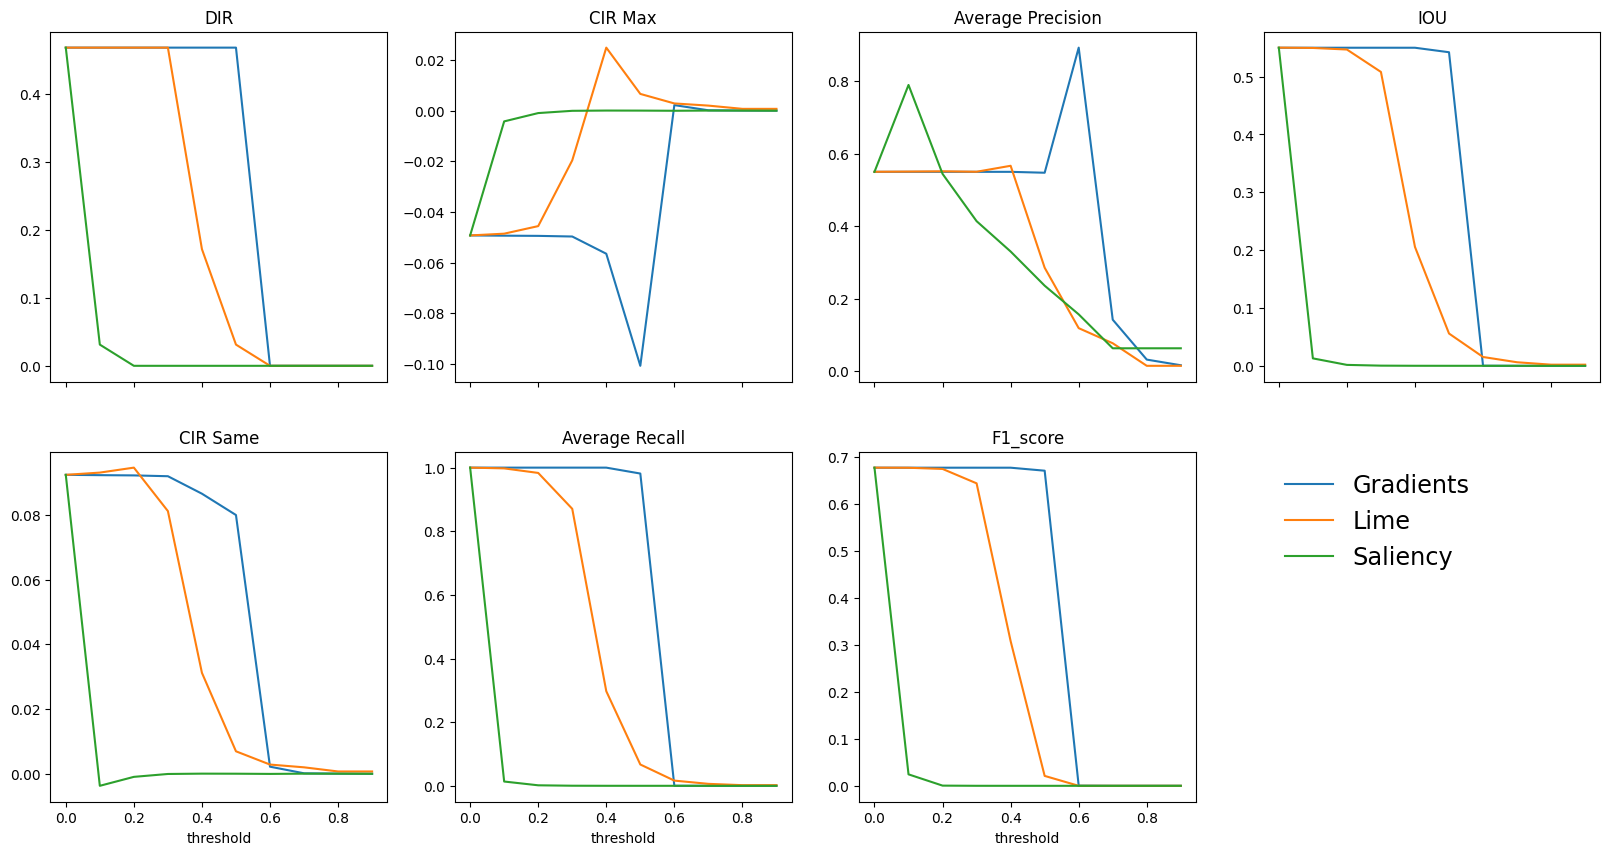

In [7]:
plot_results(df)

## Metrics for aggregates

In [9]:
df_agg = pd.DataFrame()
for i in range(16):
    df_agg = pd.concat([df_agg,pd.read_csv(path.join(metrics_dir, 'agg_explanations_{i}.csv'.format(i=i)), index_col=0)], axis=0)
    
df_agg = df_agg.groupby(by=df_agg.index).mean()

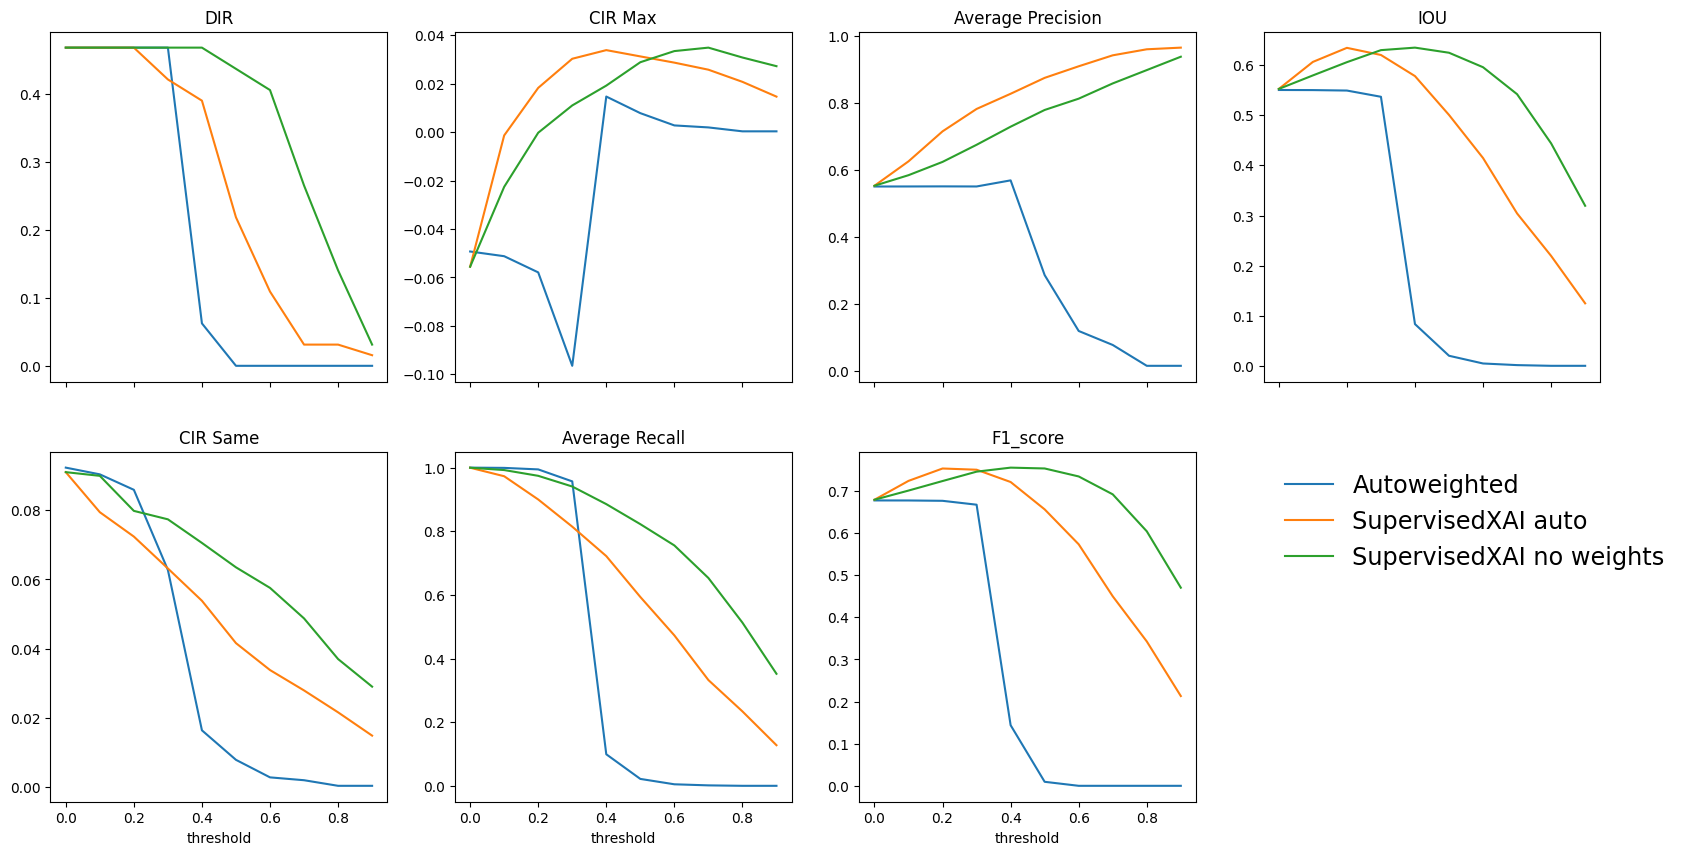

In [10]:
plot_results(df_agg)